In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import pickle

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
from matplotlib.ticker import MultipleLocator

# Load Data

In [2]:
# df_comp_details = pd.read_csv('duopoly_competition_details_quentin.csv')
# print("Nombre de saisons pour la compet 3JbhUV :", df_comp_details[df_comp_details['competition_id'] == "3JbhUV"]['selling_season'].nunique())
# print("Nombre de période dans la selling season 1 : ", df_comp_details[(df_comp_details['competition_id'] == "3JbhUV") & (df_comp_details['selling_season'] == 1)]['selling_period'].nunique())
# print("Nombre de compétitions :", df_comp_details['competition_id'].nunique())

# # On s'assure qu'il y a bien 100 saisons dans chaque compétitions
# compt_seasons_p_comp = df_comp_details.groupby('competition_id')['selling_season'].nunique()
# print("Nombre de saison par compet que l'on retrouve dans le csv :\n",compt_seasons_p_comp.unique())
# # On s'assure qu'il y a bien période dans chaque saison
# compt_periods_p_season = df_comp_details.groupby(['competition_id', 'selling_season'])['selling_period'].nunique()
# print("Nombre de période par saison que l'on retrouve dans le csv :\n",compt_periods_p_season.unique())
# df_comp_details.head()

On retrouve ici l'id unique de la compétition, la saison de la compétition, la période de la compétition, l'id du competiteur , le prix du compétiteur, le mien puis la demand, le fait que le compétiteur est de la demande ou non, la durée du calcul et enfin l'erreur ou non.

In [3]:
# df_comp_details_q2 = pd.read_csv(r"C:\Users\yannl\Documents\BHT\LearningOptimization\DynamicPricingCompet\W2_personaljob\duopoly_competition_details_quentin2.csv")
# df_comp_details_y = pd.read_csv(r"C:\Users\yannl\Documents\BHT\LearningOptimization\DynamicPricingCompet\W2_personaljob\duopoly_competition_details_yann.csv")
df_comp_details = pd.read_csv(r"C:\Users\yannl\Documents\BHT\LearningOptimization\DynamicPricingCompet\W2_personaljob\duopoly_competition_details (3).csv")
# df_comp_details = pd.concat([df_comp_details,df_comp_details_q2,df_comp_details_y], ignore_index=True, axis=0)

In [4]:
df_comp_details.groupby('competitor_id').agg({
    'competition_id' : 'nunique',
    'selling_season' : ['max', 'count']
})

competition_id selling_season       
                     nunique            max  count
competitor_id                                     
EnergeticMole              2            100  20000
NoisyMammoth               2            100  20000

## Create unique season id

Pour pouvoir travailler plus efficacement, on va créer une clé unique pour chaque saison

In [5]:
def create_unique_season_id(df):
    df['unique_season_id'] = df.apply( lambda x: 
                    "%s_%s" % (x.competition_id, x.selling_season), axis=1)
    df.drop(['competition_id', 'selling_season'], axis=1, inplace=True)
    # Réordonner pour mettre unique_season_id en première colonne
    cols = ['unique_season_id'] + [col for col in df.columns if col != 'unique_season_id']
    return df[cols]
df_comp_details = create_unique_season_id(df_comp_details)
df_comp_details.head()

,unique_season_id,selling_period,competitor_id,price_competitor,price,demand,competitor_has_capacity,calculation_duration,errors
0,34FWTM_1,1,NoisyMammoth,48.0,150.0,0,True,0.0,NaN
1,34FWTM_1,2,NoisyMammoth,81.9,150.0,0,True,0.0,NaN
2,34FWTM_1,3,NoisyMammoth,97.5,150.0,0,True,0.0,NaN
3,34FWTM_1,4,NoisyMammoth,112.6,150.0,0,True,0.0,NaN
4,34FWTM_1,5,NoisyMammoth,127.2,150.0,0,True,0.0,NaN


### Show revenue distribution over all selling season

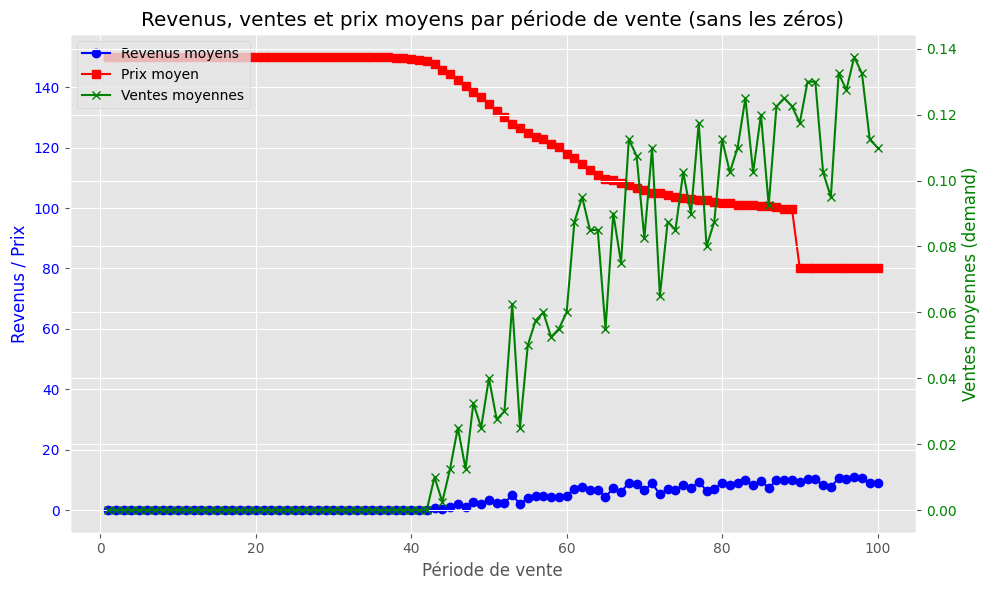

In [6]:
import matplotlib.pyplot as plt

# Calcul des revenus si ce n'est pas déjà fait
df_comp_details['revenue'] = df_comp_details['price'] * df_comp_details['demand']

# Agrégation par période de vente
df_grouped = df_comp_details.groupby('selling_period').agg({
    'revenue': 'mean',
    'demand': 'mean',
    'price': 'mean'
})

df_grouped.head()

# Création de la figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Courbe des revenus sur l'axe y principal
ax1.plot(df_grouped.index, df_grouped['revenue'], color='blue', marker='o', label='Revenus moyens')
# Courbe du prix sur le même axe y que les revenus
ax1.plot(df_grouped.index, df_grouped['price'], color='red', marker='s', label='Prix moyen')

ax1.set_xlabel("Période de vente")
ax1.set_ylabel("Revenus / Prix", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Création d'un second axe y pour les ventes
ax2 = ax1.twinx()
ax2.plot(df_grouped.index, df_grouped['demand'], color='green', marker='x', label='Ventes moyennes')
ax2.set_ylabel("Ventes moyennes (demand)", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Titre
plt.title("Revenus, ventes et prix moyens par période de vente (sans les zéros)")
fig.tight_layout()

# Légende combinée
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()


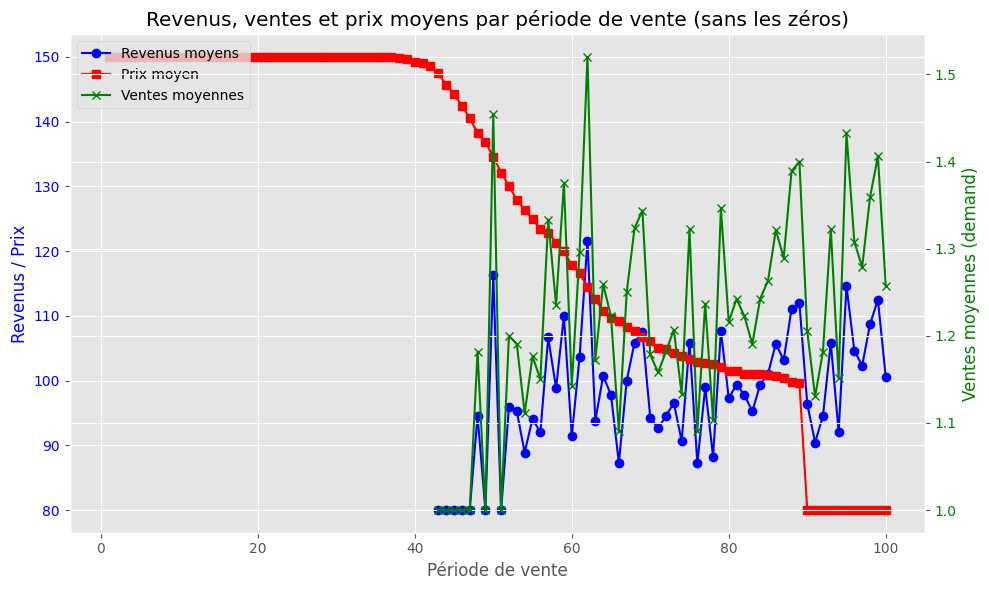

In [7]:
import matplotlib.pyplot as plt

# Calcul des revenus si ce n'est pas déjà fait
df_comp_details['revenue'] = df_comp_details['price'] * df_comp_details['demand']

# Agrégation par période de vente
# Fonction moyenne en ignorant les zéros
def mean_ignore_zeros(x):
    x_nonzero = x[x != 0]  # on filtre les valeurs non nulles
    if len(x_nonzero) == 0:
        return np.nan  # ou 0 si tu préfères
    return x_nonzero.mean()

# Agrégation par période de vente
df_grouped = df_comp_details.groupby('selling_period').agg({
    'revenue': mean_ignore_zeros,
    'demand': mean_ignore_zeros,
    'price': mean_ignore_zeros
})

df_grouped.head()

# Création de la figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Courbe des revenus sur l'axe y principal
ax1.plot(df_grouped.index, df_grouped['revenue'], color='blue', marker='o', label='Revenus moyens')
# Courbe du prix sur le même axe y que les revenus
ax1.plot(df_grouped.index, df_grouped['price'], color='red', marker='s', label='Prix moyen')

ax1.set_xlabel("Période de vente")
ax1.set_ylabel("Revenus / Prix", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Création d'un second axe y pour les ventes
ax2 = ax1.twinx()
ax2.plot(df_grouped.index, df_grouped['demand'], color='green', marker='x', label='Ventes moyennes')
ax2.set_ylabel("Ventes moyennes (demand)", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Titre
plt.title("Revenus, ventes et prix moyens par période de vente (sans les zéros)")
fig.tight_layout()

# Légende combinée
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()


In [8]:
dfx_rev = df_comp_details.groupby('unique_season_id').agg({
    'revenue' : 'sum'
}).reset_index().sort_values(by = 'revenue', ascending=False)

dfx_rev.head()

,unique_season_id,revenue
235,3t3R65_40,2800.0
217,3t3R65_24,2720.0
209,3t3R65_17,2560.0
260,3t3R65_63,2480.0
250,3t3R65_54,2400.0


Text(0, 0.5, 'Nombre de saisons')

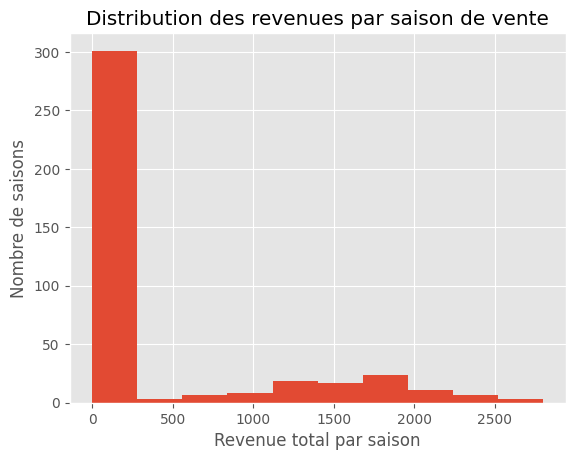

In [9]:
dfx_rev.hist()
# On affiche la légende 
plt.title("Distribution des revenues par saison de vente")
plt.xlabel("Revenue total par saison")
plt.ylabel("Nombre de saisons")

Visualize one selling season

In [10]:
id_best_seas = dfx_rev[dfx_rev['revenue'] == dfx_rev['revenue'].max()]['unique_season_id'].values[0]
df_best_season = df_comp_details[df_comp_details['unique_season_id'] == id_best_seas]


Text(0.5, 1.0, 'Revenue per season for the best season')

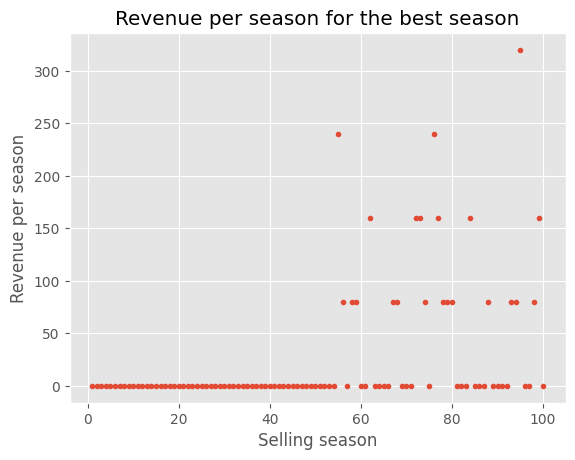

In [11]:
plt.plot(df_best_season['selling_period'], df_best_season['revenue'], marker = '.',linestyle='None')
plt.xlabel("Selling season")
plt.ylabel("Revenue per season")
plt.title("Revenue per season for the best season")

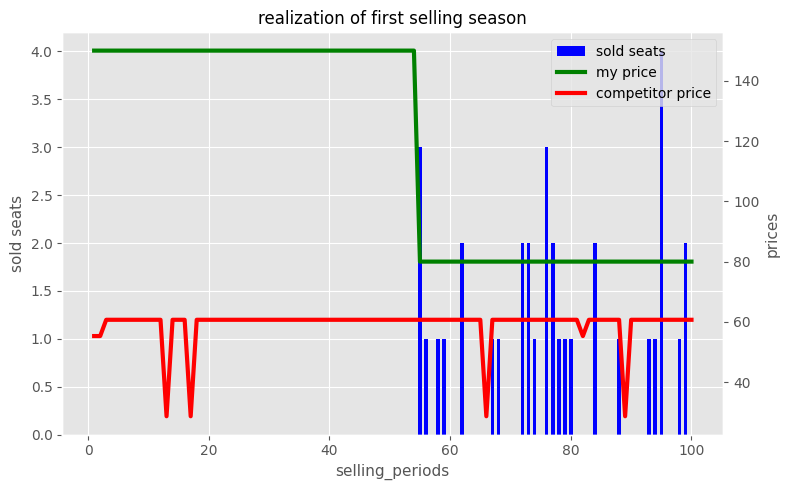

In [12]:
fig, ax = plt.subplots(figsize=(8,5))

ax.bar(df_best_season.selling_period,df_best_season.demand, color='b', width=0.6, align='center', label = 'sold seats')
ax.set_xlabel('selling_periods', size=11)
# ax.set_xticks(np.arange(min(dft.index), max(dft.index)+1, 1.0))
ax.set_ylabel("sold seats" , size=11)

ax_2 = ax.twinx()
ax_2.grid(False)
ax_2.plot(df_best_season.selling_period, df_best_season.price, color='g', linestyle='-', linewidth=3, label = 'my price')
ax_2.plot(df_best_season.selling_period, df_best_season.price_competitor, color='r', linestyle='-', linewidth=3, label = 'competitor price')
ax_2.tick_params(axis="both", labelsize=10)
ax_2.set_ylabel("prices" , size=11)

ax.tick_params(axis="both", labelsize=10)
ax.set_title("realization of first selling season", size=12)

# legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_2.get_legend_handles_labels()
ax_2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(True)
fig.tight_layout()

plt.show()

# Plot the capacity utlization curve

In [13]:
# On s'assure d'abord que le selling period sont dans le bon orde
df_best_season = df_best_season.sort_values(by = 'selling_period')

df_best_season['cum_d'] = df_best_season['demand'].cumsum()

df_best_season['capacity'] = round(df_best_season['cum_d'] / 80, 2)
df_best_season.head()

,unique_season_id,selling_period,competitor_id,price_competitor,price,demand,competitor_has_capacity,calculation_duration,errors,revenue,cum_d,capacity
23900,3t3R65_40,1,EnergeticMole,55.3,150.0,0,True,0.0,NaN,0.0,0,0.0
23901,3t3R65_40,2,EnergeticMole,55.3,150.0,0,True,0.0,NaN,0.0,0,0.0
23902,3t3R65_40,3,EnergeticMole,60.7,150.0,0,True,0.0,NaN,0.0,0,0.0
23903,3t3R65_40,4,EnergeticMole,60.7,150.0,0,True,0.0,NaN,0.0,0,0.0
23904,3t3R65_40,5,EnergeticMole,60.7,150.0,0,True,0.0,NaN,0.0,0,0.0


On en profite pour regarder si le concurrent à lui encore de la capacité.

In [14]:
df_best_season.competitor_has_capacity.value_counts()

competitor_has_capacity
True     54
False    46
Name: count, dtype: int64

On en compte 100,  ça veut dire que le concurrent à fini la saison avec des places non vendues. 

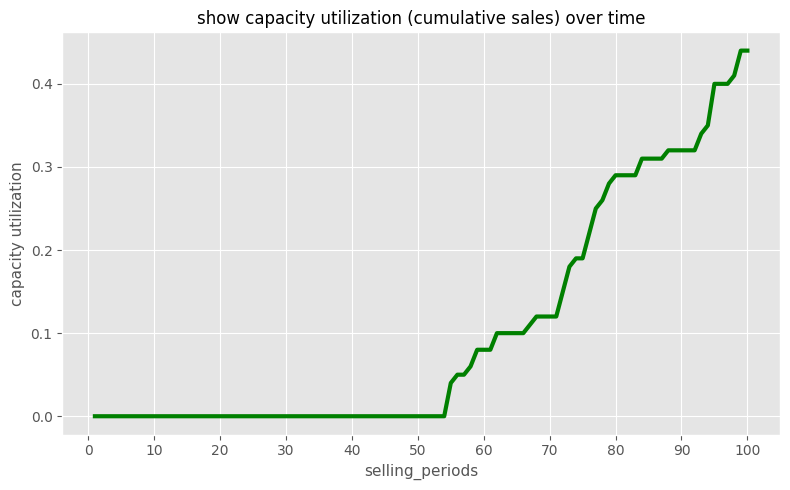

In [15]:
fig, ax = plt.subplots(figsize=(8,5))

# ax.plot(df_best_season.selling_period, df_best_season.cum_demand, color='b', 
#        width=0.6, align='center', label = 'sold seats')
ax.plot(df_best_season.selling_period, df_best_season.capacity, color='g', 
        linestyle='-', linewidth=3, label = 'capacity utilization')
ax.set_xlabel('selling_periods', size=11)
# ax.set_xticks(np.arange(min(dft.index), max(dft.index)+1, 1.0))
ax.set_ylabel("capacity utilization" , size=11)

y_majorLocator = MultipleLocator(0.1)
ax.yaxis.set_major_locator(y_majorLocator)
x_majorLocator = MultipleLocator(10)
ax.xaxis.set_major_locator(x_majorLocator)

ax.set_title("show capacity utilization (cumulative sales) over time", size=12)
# ax.legend(loc=0)

ax.grid(True)
fig.tight_layout()

plt.show()

get the selling seasons keys with the top 20% revenue generation

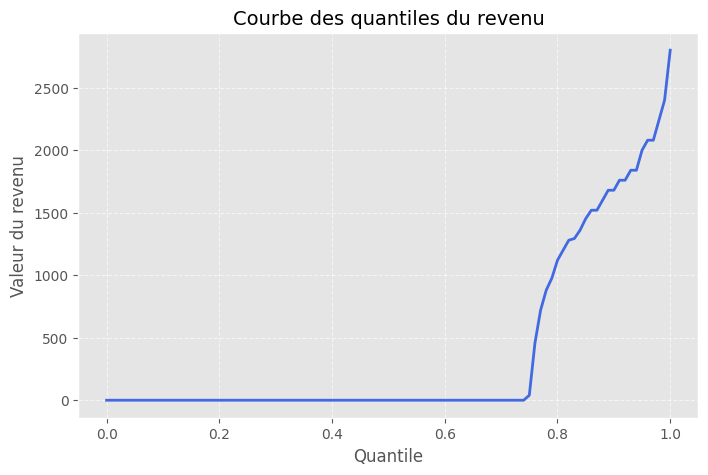

In [16]:
# Calcul des quantiles
x = np.arange(0, 1.01, 0.01)
y = dfx_rev['revenue'].quantile(x)

# Tracé
plt.figure(figsize=(8, 5))
plt.plot(x, y, color='royalblue', linewidth=2)

# Titres et axes
plt.title("Courbe des quantiles du revenu", fontsize=14)
plt.xlabel("Quantile", fontsize=12)
plt.ylabel("Valeur du revenu", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


In [17]:
top_selling_seasons = dfx_rev[dfx_rev['revenue'] >= dfx_rev['revenue'].quantile(0.80) ].unique_season_id.unique()
dfx_rev[dfx_rev.unique_season_id.isin(top_selling_seasons)].revenue.mean()

1724.4444444444443

Compute the capacity utlization curves per selling season. 